# Benchmarking Muon and AdaMuon Optimizers vs AdamW

This notebook presents a benchmark comparing the performance of **Muon** and its adaptive variant **AdaMuon** against the widely used **AdamW** optimizer.

Muon is a recent optimizer inspired by orthogonalized momentum updates, where gradients are iteratively projected toward orthogonal transformations using a truncated Newton–Schulz iteration. This design aims to improve training stability and generalization while maintaining efficiency comparable to AdamW.

AdaMuon extends this approach by incorporating adaptive second-moment normalization, blending the orthogonal geometry of Muon with the adaptive scaling behavior of Adam-like methods.

In [2]:
import os, math, time, random, json
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -----------------
# Utils
# -----------------
def set_seed(seed=123):
    random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Dataset + Tokenizer

We will use a **minimal character-level tokenizer** implemented in the `SimpleCharTokenizer` class.
Instead of relying on complex subword models such as SentencePiece or Byte-Pair Encoding (BPE), this tokenizer directly builds its vocabulary from the **unique characters** present in the dataset (WikiText-2), plus a few special tokens: `<pad>` for padding, `<bos>` for the beginning of a sequence, and `<eos>` for the end.

Each character in the text is assigned a unique integer ID, creating two lookup tables:

* `stoi` (string-to-index) for encoding text into token IDs
* `itos` (index-to-string) for decoding IDs back into text

The experiments use **WikiText-2**. It is derived from verified, clean Wikipedia articles and contains around **2 million tokens** of natural English text. Compared to larger corpora like WikiText-103, WikiText-2 is much smaller and easier to train on, making it ideal for quick experiments. The dataset provides both training and validation splits.

In [3]:
class SimpleCharTokenizer:
    def __init__(self, text, vocab_extra="\n"):
        chars = sorted(list(set(text)))
        for c in vocab_extra:
            if c not in chars:
                chars.append(c)
        self.itos = ["<pad>", "<bos>", "<eos>"] + chars
        self.stoi = {s:i for i,s in enumerate(self.itos)}
        self.pad_id, self.bos_id, self.eos_id = 0, 1, 2
    def encode(self, s): return [self.bos_id] + [self.stoi.get(c, self.pad_id) for c in s] + [self.eos_id]
    def decode(self, ids): return "".join(self.itos[i] for i in ids if i>=3)

def load_text():
    p = "/kaggle/input/wikitext/wikitext-2/wiki.train.tokens"
    if os.path.exists(p):
        train = Path(p).read_text()
        valid = Path(p.replace("train", "valid")).read_text()
        return train, valid
    raise FileNotFoundError("WikiText-2 not found in Kaggle input path")

class LMBlockDataset(Dataset):
    def __init__(self, ids, ctx):
        self.ctx = ctx
        self.data = torch.tensor(ids, dtype=torch.long)
        self.n = (len(self.data)-1)//ctx
    def __len__(self): return self.n
    def __getitem__(self, i):
        s = i*self.ctx
        x = self.data[s:s+self.ctx]
        y = self.data[s+1:s+self.ctx+1]
        return x, y

## GPT-like Decoder

The model begins with an **embedding layer** (`nn.Embedding`) that maps each token ID from the vocabulary into a dense vector of size **256** (`d=256`). To preserve word order, a learnable **positional embedding** (`self.pos`) of shape `(1, 256, 256)` is added to these token representations, allowing the model to encode sequential information within a fixed context length of **256 tokens** (`ctx=256`).

The network stacks **4 identical Transformer blocks** (`nl=4`), each composed of:

1. **LayerNorm (d=256)** → normalizes activations for stability.
2. **Multi-Head Self-Attention (MHA)** with:

   * **4 attention heads** (`nheads=4`),
   * Each head operating on **64-dimensional** subspaces (`d / nheads = 64`),
   * A learned projection layer producing `3 × d = 768` features for queries, keys, and values.
   * A **causal mask** ensures that each token can only attend to past tokens (autoregressive setup).
   * The attended features are combined and projected back to dimension **256**.
   
3. **Feed-Forward Network (FFN)**:

   * A two-layer MLP expanding to **1024 units** (`dff=1024`) with a **GELU** activation,
   * Then projected back to **256 dimensions** to match the model depth.
4. **Residual connections** and **dropout (p=0.0)** are applied to improve training dynamics and prevent overfitting.

Despite its compactness (~3.4M parameters), the model captures the essential structure of larger GPT models, making it ideal for controlled optimizer benchmarks.


In [4]:
class MHA(nn.Module):
    def __init__(self, d, nheads, ctx):
        super().__init__()
        self.nh = nheads
        self.dk = d // nheads
        self.qkv = nn.Linear(d, 3*d, bias=False)
        self.out = nn.Linear(d, d, bias=False)
        self.register_buffer("mask", torch.tril(torch.ones(ctx, ctx)).view(1,1,ctx,ctx))
        
    def forward(self, x):
        B,T,C = x.shape
        qkv = self.qkv(x).view(B, T, self.nh, 3, self.dk).permute(0,2,3,1,4)
        q,k,v = qkv[:,:,0], qkv[:,:,1], qkv[:,:,2]
        att = (q @ k.transpose(-2,-1)) / math.sqrt(self.dk)
        att = att.masked_fill(self.mask[:,:,:T,:T]==0, float("-inf"))
        att = F.softmax(att, dim=-1)
        z = att @ v
        z = z.transpose(1,2).contiguous().view(B,T,C)
        return self.out(z)

class Block(nn.Module):
    def __init__(self, d, nheads, dff, ctx, pdrop=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d)
        self.att = MHA(d, nheads, ctx)
        self.ln2 = nn.LayerNorm(d)
        self.ff = nn.Sequential(nn.Linear(d, dff), nn.GELU(), nn.Linear(dff, d))
        self.drop = nn.Dropout(pdrop)
        
    def forward(self, x):
        x = x + self.drop(self.att(self.ln1(x)))
        x = x + self.drop(self.ff(self.ln2(x)))
        return x

class TinyGPT(nn.Module):
    def __init__(self, vocab, ctx=256, nl=4, d=256, nheads=4, dff=1024):
        super().__init__()
        self.ctx = ctx
        self.emb = nn.Embedding(vocab, d)
        self.pos = nn.Parameter(torch.zeros(1, ctx, d))
        self.blocks = nn.Sequential(*[Block(d,nheads,dff,ctx) for _ in range(nl)])
        self.ln = nn.LayerNorm(d)
        self.head = nn.Linear(d, vocab, bias=False)
        
    def forward(self, idx, targets=None):
        x = self.emb(idx) + self.pos[:, :idx.size(1), :]
        x = self.blocks(x)
        x = self.ln(x)
        logits = self.head(x)
        if targets is None: return logits, None
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

## Muon Core

- `_ns5_orthogonalize(M)`

This function performs **5-step Newton–Schulz orthogonalization** on a matrix `M`.
It normalizes `M` by its Frobenius norm, then iteratively refines it toward an orthogonal transformation $ X \approx U V^T $ using a cubic polynomial approximation with coefficients $ a=3.4445, b=-4.7750, c=2.0315 $.
In practice, this ensures that the optimizer’s update directions become **decorrelated and geometrically stable**, preventing redundant gradient directions and improving convergence.
The function is decorated with `@torch.no_grad()` to avoid interfering with gradient computation.

- `_is_matrix_param(p)`

A simple helper that returns `True` if a parameter tensor `p` is **two-dimensional** (i.e., a weight matrix in linear or convolutional layers). Muon applies orthogonalization only to such matrix parameters, while biases and 1D tensors use a simpler update rule.

- `_rms_align(O, target=0.2)`

This function rescales a matrix `O` so that its **root-mean-square (RMS) value** matches a fixed **target amplitude** (default = 0.2). It normalizes the update magnitude across layers, preventing excessively large or small step sizes.
This **global RMS alignment** step contributes to Muon’s training stability and consistency across different parameter scales.


In [5]:
@torch.no_grad()
def _ns5_orthogonalize(M):
    fro = torch.linalg.vector_norm(M)
    if fro == 0: return torch.zeros_like(M)
    X = M / fro
    a, b, c = 3.4445, -4.7750, 2.0315
    for _ in range(5):
        XtX = X @ X.transpose(-1, -2)
        X = a*X + b*(XtX @ X) + c*((XtX @ XtX) @ X)
    return X

def _is_matrix_param(p): 
    return p.ndim == 2
    
def _rms_align(O, target=0.2):
    if O.numel() == 0: return O
    rms = torch.linalg.vector_norm(O)/math.sqrt(O.numel())
    if rms==0: return O
    return O*(target/rms)

The **`GeneralizedMuon`** class implements a unified optimizer that merges the principles of **Muon** and **AdaMuon** into a single configurable algorithm. It extends `torch.optim.Optimizer` and supports two operational modes:

- **`adaptive=False` → Muon mode**: uses orthogonalized momentum without elementwise adaptivity.
- **`adaptive=True` → AdaMuon mode**: combines Muon’s orthogonalization with adaptive second-moment normalization (similar to Adam).

During each `step()` call, the optimizer performs several operations:

1. **Weight Decay & Momentum Update** :
   Each parameter gradient `g` is first regularized with decoupled weight decay (`p.add_(p, alpha=-lr*wd)`).
   Then, a **momentum buffer** `v` is updated using an exponential moving average of gradients controlled by the coefficient `μ`.
   The **Nesterov lookahead** step (`m = v + μ * (v - v_prev)`) improves responsiveness to gradient direction changes.

2. **Parameter Type Handling** :
   For **1D tensors** (e.g., biases, LayerNorm weights), the optimizer skips orthogonalization and applies either:

   * a standard momentum update (Muon mode), or
   * an **adaptive elementwise normalization** using the second-moment estimate `v2` (AdaMuon).

3. **Orthogonalized Update (for 2D matrices)** :
   For matrix-shaped parameters (e.g., linear layer weights), the update direction is first **sign-stabilized** (`S = sign(m)`), then **orthogonalized** via the 5-step Newton–Schulz iteration (`_ns5_orthogonalize(S)`).
   In adaptive mode, an additional **per-element normalization** divides by the square root of the second-moment accumulator (`v2`), akin to Adam’s variance correction.

4. **RMS Alignment and Update** :
   Finally, all updates are globally rescaled to match a fixed RMS target (default `0.2`), ensuring uniform step magnitudes across layers, before being applied to parameters (`p.add_(O, alpha=-lr)`).

This algorithm combines momentum geometry (Muon) with adaptive scaling (Adam) in a single optimizer. Muon mode prioritizes **stable, orthogonal gradient flow**, while AdaMuon mode adds **variance normalization**.


In [6]:
class GeneralizedMuon(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, weight_decay=0.1, momentum=0.95, beta2=0.999, 
                 eps=1e-8, rms_target=0.2, adaptive=False):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum, 
                        beta2=beta2, eps=eps, rms_target=rms_target, adaptive=adaptive)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            lr = group["lr"]; wd = group["weight_decay"]
            mu = group["momentum"]; beta2 = group["beta2"]
            eps = group["eps"]; tgt = group["rms_target"]
            adaptive = group["adaptive"]

            for p in group["params"]:
                if p.grad is None: continue
                g = p.grad
                if wd != 0: p.add_(p, alpha=-lr*wd)
                state = self.state.setdefault(p, {})
                v = state.get("v", torch.zeros_like(p))
                v.mul_(mu).add_(g, alpha=(1-mu))
                state["v"] = v
                m = v + mu*(v - state.get("v_prev", torch.zeros_like(v)))
                state["v_prev"] = v.clone()

                if p.ndim < 2:
                    if adaptive:
                        v2 = state.get("v2", torch.zeros_like(p))
                        v2.mul_(beta2).addcmul_(m,m,value=(1-beta2))
                        state["v2"]=v2
                        p.add_(m/(v2.sqrt()+eps), alpha=-lr)
                    else:
                        p.add_(m, alpha=-lr)
                    continue

                S = torch.sign(m)
                O = _ns5_orthogonalize(S)

                if adaptive:
                    v2 = state.get("v2", torch.zeros_like(O))
                    v2.mul_(beta2).addcmul_(O,O,value=(1-beta2))
                    state["v2"]=v2
                    O = O/(v2.sqrt()+eps)

                O = _rms_align(O, tgt)
                p.add_(O, alpha=-lr)
        return loss

## Training

The model is trained for **15 epochs** using the three optimizers: **AdamW**, **Muon**, and **AdaMuon**.

For **AdamW**, we use a learning rate of `1×10^-3` with weight decay = 0.1, following its standard setup for LLM fine-tuning.
For **Muon**, we set a higher learning rate of `3×10^-3`, momentum = 0.95, and RMS target = 0.1 to stabilize orthogonalized gradient updates.
Finally, **AdaMuon** extends Muon by adding **elementwise second-moment normalization** ($\beta_2 = 0.999, \varepsilon = 1\times10^{-8}$) for adaptive scaling.

All optimizers share a cosine learning rate schedule with linear warm-up during the first 1,000 steps, and mixed-precision training (`torch.cuda.amp`) is enabled for efficiency. The goal is to compare final validation loss across optimizers, highlighting how Muon and AdaMuon improve gradient geometry and adaptivity over the AdamW baseline.

Params: 3.37M


/tmp/ipykernel_37/774345677.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_37/774345677.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_37/774345677.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[adamw] epoch 1 | val 2.207
[adamw] epoch 2 | val 1.492
[adamw] epoch 3 | val 1.292
[adamw] epoch 4 | val 1.234
[adamw] epoch 5 | val 1.202
[adamw] epoch 6 | val 1.180
[adamw] epoch 7 | val 1.161
[adamw] epoch 8 | val 1.144
[adamw] epoch 9 | val 1.129
[adamw] epoch 10 | val 1.116
[adamw] epoch 11 | val 1.108
[adamw] epoch 12 | val 1.098
[adamw] epoch 13 | val 1.092
[adamw] epoch 14 | val 1.088
[adamw] epoch 15 | val 1.087
Params: 3.37M
[muon] epoch 1 | val 2.261
[muon] epoch 2 | val 1.411
[muon] epoch 3 | val 1.258
[muon] epoch 4 | val 1.219
[muon] epoch 5 | val 1.198
[muon] epoch 6 | val 1.187
[muon] epoch 7 | val 1.178
[muon] epoch 8 | val 1.169
[muon] epoch 9 | val 1.163
[muon] epoch 10 | val 1.155
[muon] epoch 11 | val 1.148
[muon] epoch 12 | val 1.140
[muon] epoch 13 | val 1.134
[muon] epoch 14 | val 1.128
[muon] epoch 15 | val 1.127
Params: 3.37M
[adamuon] epoch 1 | val 2.187
[adamuon] epoch 2 | val 1.323
[adamuon] epoch 3 | val 1.219
[adamuon] epoch 4 | val 1.185
[adamuon] epoch

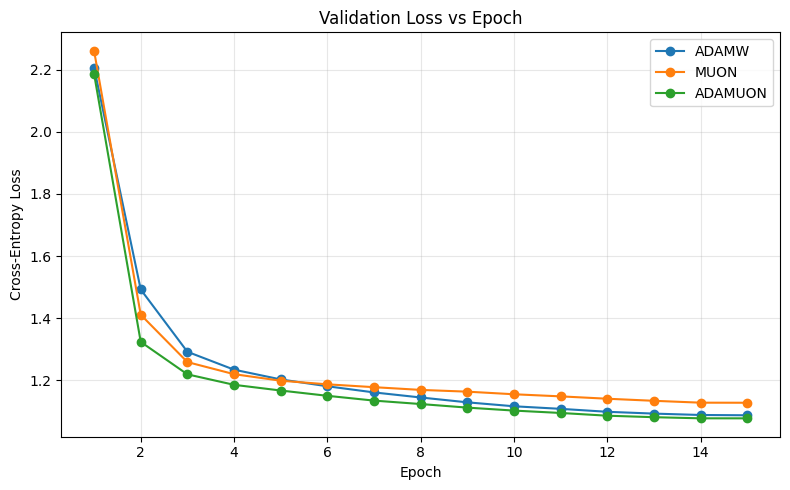

In [7]:
def get_groups(model):
    matrix_params, other_params = [], []
    for _,p in model.named_parameters():
        if not p.requires_grad: continue
        (matrix_params if _is_matrix_param(p) else other_params).append(p)
    return [{"params": matrix_params}, {"params": other_params}]

def run_one(optimizer_name, device="cuda", epochs=6, seed=123):
    set_seed(seed)
    train_txt, val_txt = load_text()

    tok = SimpleCharTokenizer(train_txt + val_txt)
    train_ids = []; val_ids = []
    for ln in train_txt.splitlines(): train_ids += tok.encode(ln+"\n")
    for ln in val_txt.splitlines(): val_ids += tok.encode(ln+"\n")

    ctx=256; nl=4; d=256; nheads=4; dff=1024
    model = TinyGPT(len(tok.itos), ctx, nl, d, nheads, dff).to(device)
    print(f"Params: {count_params(model)/1e6:.2f}M")

    train_ds = LMBlockDataset(train_ids, ctx); val_ds = LMBlockDataset(val_ids, ctx)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, drop_last=False, num_workers=2, pin_memory=True)

    steps_per_epoch = len(train_loader)
    warmup = min(1000, steps_per_epoch*2)
    max_lr = 3e-3 if optimizer_name!="adamw" else 1e-3
    min_lr = max_lr/20

    groups = get_groups(model)
    if optimizer_name == "adamw":
        opt = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=0.1)
    elif optimizer_name == "muon":
        opt = GeneralizedMuon(groups, lr=max_lr, weight_decay=0.1, momentum=0.95, rms_target=0.1, adaptive=False)
    elif optimizer_name == "adamuon":
        opt = GeneralizedMuon(groups, lr=max_lr, weight_decay=0.1, momentum=0.95, rms_target=0.1, adaptive=True)
    else:
        raise ValueError(optimizer_name)

    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    global_step=0; val_losses=[]

    for ep in range(1, epochs+1):
        model.train()
        for xb,yb in train_loader:
            xb,yb = xb.to(device), yb.to(device)

            if global_step<warmup:
                lr=max_lr*(global_step+1)/warmup
            else:
                t=(global_step-warmup)/max(1,steps_per_epoch*epochs-warmup)
                lr=min_lr+0.5*(max_lr-min_lr)*(1+math.cos(math.pi*min(t,1.0)))
            for pg in opt.param_groups: pg["lr"]=lr

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                _, loss = model(xb,yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            global_step+=1

        model.eval()
        with torch.no_grad():
            losses=[]
            for xb,yb in val_loader:
                xb,yb = xb.to(device), yb.to(device)
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    _,l=model(xb,yb)
                losses.append(l.item())
        val_loss=sum(losses)/len(losses)
        print(f"[{optimizer_name}] epoch {ep} | val {val_loss:.3f}")
        val_losses.append(val_loss)

    return val_losses

# -----------------
# Main
# -----------------
if __name__=="__main__":
    device="cuda" if torch.cuda.is_available() else "cpu"
    all_logs={}; names=["adamw","muon","adamuon"]

    for name in names:
        try:
            all_logs[name]=run_one(name, device=device, epochs=15, seed=123)
        except Exception as e:
            print(f"Skip {name}: {e}")

    plt.figure(figsize=(8,5))
    for name in all_logs:
        plt.plot(range(1,len(all_logs[name])+1), all_logs[name], marker="o", label=name.upper())
    plt.title("Validation Loss vs Epoch")
    plt.xlabel("Epoch"); plt.ylabel("Cross-Entropy Loss")
    plt.grid(True,alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig("benchmark.png")
    plt.show()

## Conclusion

All three optimizers exhibit smooth and stable convergence, with rapid loss reduction during the first few epochs followed by gradual refinement toward a stable minimum.

- **AdamW** starts with an initial validation loss of **2.21**, quickly dropping to **1.29** by epoch 3 and reaching **1.09** at epoch 15.
- **Muon**, which applies orthogonalized momentum updates, starts slightly higher (**2.26**) and converges more gradually, stabilizing around **1.13** after 15 epochs. Its slower descent suggests stronger regularization and smoother gradient flow, characteristic of its orthogonalization mechanism.
- **AdaMuon**, the adaptive variant, achieves the best overall results: it converges faster in the early stages (**1.32** at epoch 2 vs. 1.49 for AdamW and 1.41 for Muon) and consistently maintains lower validation losses, reaching **1.077** by epoch 15, the lowest among the three.

The plot confirms this trend: AdamW and Muon show similar mid-epoch behavior, but **AdaMuon** maintains a small yet consistent edge throughout training. This suggests that adding adaptive second-moment normalization to Muon improves learning efficiency and stability without sacrificing its orthogonalization benefits.

In summary, **AdamW** remains a strong baseline, **Muon** provides better geometric conditioning at the cost of slightly slower convergence, and **AdaMuon** combines both strengths, delivering the most efficient and stable optimization dynamics for this small-scale language model.
